## Домашняя работа №1. Titanik
Дедлайн -- **11.10.18 23:59**

Выполненные задания можно либо присылать на почту gaintseva@phystech.edu, либо загружать в папку в своем репозитории на GitHub. Если загружаете в репозиторий, после загрузки выполненного дз делайте pull request в мой репозиторий или пишите мне в телеграме/на почту, что сделали домашнее задание.

----------------------

В этом задании мы с помощью изученных на семинаре библиотек поиграемся с датасетом Titanik для вот это соренования: https://www.kaggle.com/c/titanic

В этом задании мы не будем тренировать модели и предсказывать результаты, а только научимся работать с данными, обрабатывать из так, чтобы после на них можно было обучать модели машинного обучения. Это пригодится Вам на следующем занятии.

Данные скачивать с сайта не нужно, они уже лежат в папке рядом с этим ноутбуком.

Начем!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Часть 1. Смотрим на данные

#### Задание 1.1

С помощью библиоткеи pandas загрузите данные из файла train_titanik.csv в память и выведите первые 5 записей на экран:

In [2]:
data = pd.read_csv('./train_titanik.csv')
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Как видно, в данных есть пропуски (NAN), некоторые данные категориальные (не числовые). Как мы помним с предыдущего занятия, чтобы на этих данных можно было обучать модели, нужно заполнить пропуски (избавиться от NaN) и перевести категориальные признаки в числовые. Этим мы и займемся.

#### Задание 1.2

Выделим из данных колонку с ответами (целевой переменной, Y) и в data оставим все остальные колонки

P.S. можно (и желательно) воспользоваться методом drop(): https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html:

In [3]:
y = data['Survived']
data = data.drop('Survived', axis = 1)

In [4]:
data.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Давайте для начала посмотрим, какие в данных есть колонки и какого типа данные в низ записаны:

In [5]:
print(data.columns)
print(data.dtypes)

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


И также посмотрим, в каких столбцах данных содержатся NaN:

In [6]:
data.columns[data.isnull().any()].tolist()

['Age', 'Cabin', 'Embarked']

#### Задание 1.3

Если хотите, можете посмотреть на связь разных признаков между собой на картинке. Заметьте, что пока мы не перевели категориальные признаки в числовые, мы можем смотреть только на числовые признаки. Давайте, например, посмотрим на связь признаков Age и SibSp 

(подсказка: для этого подойдет функция scatter(), пример ее применения можно найти из семинара или документации matplotlib. Не забудтьте раскрасить точки в 2 цвета в зависимости от значений целевой переменной):

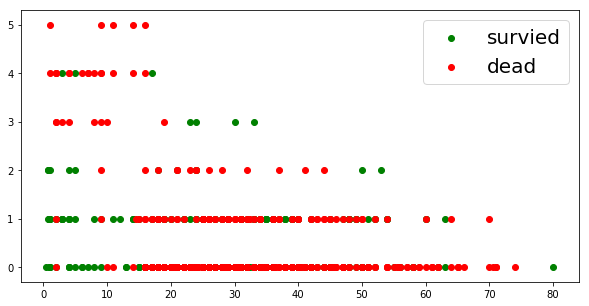

In [7]:
plt.figure(figsize=(10, 5))
plt.scatter(data['Age'][y==1], data['SibSp'][y==1], color='g', label='survied')
plt.scatter(data['Age'][y==0], data['SibSp'][y==0], color='r', label='dead')
plt.legend(fontsize=20, loc=1)
plt.show()

### Часть 2: Заполнение NaN

Начнем с того, что заполним NaN в колонках, где они есть, какими-нибудь значениями. Для того, чтобы лучше понять, какие значения для пропусков выбрать, полезно посмотреть на данные с точки зрения каких-нибудь статистик (найти среднее по колонке, медиану, самое часто встречающееся значения и т.п.) 

#### 1.
Возраст человека может быть любым чтслом от 0 до \inf. Поэтому, кажется, что для колонки Age смотреть на количество строк с каждым отдельным значеним не имеет смысла. Больший смысл имеет найти значения статистик.

#### Задание 2.1: 
Для колонки Age найдите ее максимальное, минимальное, среднее значения и медиану, напечатайте результаты 

(подсказка: если поиск этих значений работает долго, вспомните, что для np.array() это все будет работать намного быстрее): 

In [8]:
age_max = data['Age'].max()
age_min = data['Age'].min()
age_mean = data['Age'].mean()
age_median = data['Age'].median()
print ('max = ', age_max, 'min = ', age_min, 'mean = ', age_mean, 'median = ', age_median)

max =  80.0 min =  0.42 mean =  29.69911764705882 median =  28.0


#### 2. 
Колонка Embarked, наоборот, содержит категориальный признак, который имеет мало разных значений в датасете. Поэтому для него как раз имеет смысл найти количества записей с каждым значением в датасете.

#### Задание 2.2: 
Для колонки Embarked для каждого значения в этой колонке найдите, сколько раз оно встречается. 

(подсказка: Это можно сделать руками, а можно с помощью метода describe())

In [9]:
data.describe(include = 'all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Strom, Miss. Telma Matilda",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [10]:
data[data['Embarked'].isnull() == True]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [11]:
a = data['Embarked'].unique()
for i in range (0,a.size):
    print (a[i], ' ', data['Embarked'][data['Embarked'] == a[i]].count())
    # хз что делать с nan, не считает
print ('NaN руками посчитанный', data['PassengerId'][data['Embarked'].isnull() == True].count())

S   644
C   168
Q   77
nan   0
NaN руками посчитанный 2


#### 3.
А вот что делать с колонкой Cabin, сразу непонятно. Она категориальная, и значений в ней много разных. 

#### Задание 2.3: 
Выведите описание столбца Cabin с помощью describe()

In [12]:
data['Cabin'].describe()

count             204
unique            147
top       C23 C25 C27
freq                4
Name: Cabin, dtype: object

#### 4.
Теперь, когда мы видим перед собой больше информации о колонках с NaN, пора эти NaN на что-нибудь заменить. На что -- решать Вам. Не обязательно при этом использовать те величины, которые мы находили в пунктах 2.1 - 2.3.

#### Задание 2.4: 
Заполните пропуски в data отдельно для Age, Embarked и Cabin. Объясните, почему Вы решили заполнить их именно так.

P.S. NaN удобно заменять с помощью метода .fillna() (о нем было на семинаре, можно посмотреть в ноутбуке numpy.ipynb). Обратите внимание, что метод НЕ изменяет объект, к которому был применен, а возвращает новый.

In [13]:
data['Pclass'].unique()

array([3, 1, 2], dtype=int64)

In [14]:
data['Sex'].unique()

array(['male', 'female'], dtype=object)

In [15]:
data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [16]:
print ('male ',data['Age'][data['Sex']=='male'].median(), 'female ', data['Age'][data['Sex']=='female'].median())

male  29.0 female  27.0


In [17]:
#заполним медианным возрастом для каждого класса/пола, т.к. больше нет критериев, хотя бы косвенно характеризующих возраст (если будет время, пока тупо медианой для пола)
data['Age'][data['Sex']=='male']=data['Age'][data['Sex']=='male'].fillna(data['Age'][data['Sex']=='male'].median())  
data['Age'][data['Sex']=='female']=data['Age'][data['Sex']=='female'].fillna(data['Age'][data['Sex']=='female'].median()) 

#заполним самым частым значением embarked
data['Embarked']=data['Embarked'].fillna('S') 

#уберем столбец, т.к. плохо заполнен и может привести к ошибочным суждениям 
data = data.drop('Cabin', axis = 1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,3,"Moran, Mr. James",male,29.0,0,0,330877,8.4583,Q
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C


Все, теперь в data не должно быть NaN. Код в ячейке ниже это проверяет. Если он выдал ошибку, значит, Вы не избавились от всех NaN в данных

In [19]:
assert not data.isnull().values.any()

### Часть 3. Перевод категориальных признаков в числа

Как мы помним с лекции, модели (за редким исключением) умеют работать только с числовыми признаками. Поэтому все нечисловые признаки придется превратить в числовые. Этим мы сейчас и займемся.

#### Задание 3.1

Для начала давайте подумаем, что делать с колонкой Name. В ней каждое значение уникальное, и если превращать эти значения в числа, каждому человеку мы поставим в соответствие уникальное число. То есть, получится колонка такая же, как PassengerId. Наверное, нам это не нужно. Поэтому давайте просто удалим эту колонку:

P.S. можно (и желательно) воспользоваться методом drop(): https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html:

In [20]:
data = data.drop('Name', axis = 1)

Посмотрим опять, какие данные у нас остались и что пока получилось:

In [21]:
data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,3,male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,female,38.0,1,0,PC 17599,71.2833,C
2,3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,female,35.0,1,0,113803,53.1000,S
4,5,3,male,35.0,0,0,373450,8.0500,S


In [22]:
print(data.columns)
print(data.dtypes)

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked'],
      dtype='object')
PassengerId      int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object


In [23]:
data.dtypes == object

PassengerId    False
Pclass         False
Sex             True
Age            False
SibSp          False
Parch          False
Ticket          True
Fare           False
Embarked        True
dtype: bool

#### Задание 3.2
Напишите функцию, которая будет превращать колонку с категориальными признаками в колонку с числовыми признаками:

(подсказка: будет работать быстрее, если работать не с pd.DataFrame, а перевести в np.array())

In [55]:
df1 = data.copy(deep=True) #копия про запас

In [56]:
def categorical_to_numeric(column):
    """
    column: колонка значений типа pd.DataFrame
    функция возвращает np.array() с новыми числовыми значениями этой колонки
    """
    data[a] = data[column].rank() / data[column].count()   

In [57]:
for_change = data.columns[(data.dtypes == object) == True] 

In [58]:
for i in range (0, for_change.size):
    a=for_change[i]
    categorical_to_numeric(a)    

Переведем колонки и категориальными признаками в числовые с помощью только что написанной Вами функции:

In [54]:
for column in data.columns:
    if data[column].dtypes == object:
        data[column] = categorical_to_numeric(data[column])

KeyError: "['male' 'female' 'female' 'female' 'male' 'male' 'male' 'male' 'female'\n 'female' 'female' 'female' 'male' 'male' 'female' 'female' 'male' 'male'\n 'female' 'female' 'male' 'male' 'female' 'male' 'female' 'female' 'male'\n 'male' 'female' 'male' 'male' 'female' 'female' 'male' 'male' 'male'\n 'male' 'male' 'female' 'female' 'female' 'female' 'male' 'female' 'female'\n 'male' 'male' 'female' 'male' 'female' 'male' 'male' 'female' 'female'\n 'male' 'male' 'female' 'male' 'female' 'male' 'male' 'female' 'male'\n 'male' 'male' 'male' 'female' 'male' 'female' 'male' 'male' 'female'\n 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'female' 'male' 'male'\n 'female' 'male' 'female' 'female' 'male' 'male' 'female' 'male' 'male'\n 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'female' 'male' 'female'\n 'male' 'male' 'male' 'male' 'male' 'female' 'male' 'male' 'female' 'male'\n 'female' 'male' 'female' 'female' 'male' 'male' 'male' 'male' 'female'\n 'male' 'male' 'male' 'female' 'male' 'male' 'male' 'male' 'female' 'male'\n 'male' 'male' 'female' 'female' 'male' 'male' 'female' 'male' 'male'\n 'male' 'female' 'female' 'female' 'male' 'male' 'male' 'male' 'female'\n 'male' 'male' 'male' 'female' 'male' 'male' 'male' 'male' 'female' 'male'\n 'male' 'male' 'male' 'female' 'male' 'male' 'male' 'male' 'female'\n 'female' 'male' 'male' 'male' 'male' 'female' 'male' 'male' 'male' 'male'\n 'female' 'male' 'male' 'female' 'male' 'male' 'male' 'female' 'male'\n 'female' 'male' 'male' 'male' 'female' 'male' 'female' 'male' 'female'\n 'female' 'male' 'male' 'female' 'female' 'male' 'male' 'male' 'male'\n 'male' 'female' 'male' 'male' 'female' 'male' 'male' 'female' 'male'\n 'male' 'male' 'female' 'female' 'male' 'female' 'male' 'male' 'male'\n 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'female' 'female' 'male'\n 'male' 'female' 'male' 'female' 'male' 'female' 'male' 'male' 'female'\n 'female' 'male' 'male' 'male' 'male' 'female' 'female' 'male' 'male'\n 'male' 'female' 'male' 'male' 'female' 'female' 'female' 'female' 'female'\n 'female' 'male' 'male' 'male' 'male' 'female' 'male' 'male' 'male'\n 'female' 'female' 'male' 'male' 'female' 'male' 'female' 'female' 'female'\n 'male' 'male' 'female' 'male' 'male' 'male' 'male' 'male' 'male' 'male'\n 'male' 'male' 'female' 'female' 'female' 'male' 'female' 'male' 'male'\n 'male' 'female' 'male' 'female' 'female' 'male' 'male' 'female' 'male'\n 'male' 'female' 'female' 'male' 'female' 'female' 'female' 'female' 'male'\n 'male' 'female' 'female' 'male' 'female' 'female' 'male' 'male' 'female'\n 'female' 'male' 'female' 'male' 'female' 'female' 'female' 'female' 'male'\n 'male' 'male' 'female' 'male' 'male' 'female' 'male' 'male' 'male'\n 'female' 'male' 'male' 'male' 'female' 'female' 'female' 'male' 'male'\n 'male' 'male' 'male' 'male' 'male' 'male' 'female' 'female' 'female'\n 'female' 'male' 'male' 'female' 'male' 'male' 'male' 'female' 'female'\n 'female' 'female' 'male' 'male' 'male' 'male' 'female' 'female' 'female'\n 'male' 'male' 'male' 'female' 'female' 'male' 'female' 'male' 'male'\n 'male' 'female' 'male' 'female' 'male' 'male' 'male' 'female' 'female'\n 'male' 'female' 'male' 'male' 'female' 'male' 'male' 'female' 'male'\n 'female' 'male' 'male' 'male' 'male' 'female' 'male' 'male' 'female'\n 'male' 'male' 'female' 'female' 'female' 'male' 'female' 'male' 'male'\n 'male' 'female' 'male' 'male' 'female' 'female' 'male' 'male' 'male'\n 'female' 'female' 'male' 'male' 'female' 'female' 'female' 'male' 'male'\n 'female' 'male' 'male' 'female' 'male' 'male' 'female' 'male' 'female'\n 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'female' 'female'\n 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'male'\n 'female' 'male' 'male' 'female' 'female' 'female' 'male' 'male' 'male'\n 'male' 'female' 'male' 'male' 'male' 'female' 'male' 'female' 'female'\n 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'female'\n 'male' 'female' 'male' 'male' 'female' 'female' 'female' 'female' 'male'\n 'female' 'male' 'male' 'male' 'male' 'male' 'male' 'female' 'male' 'male'\n 'female' 'male' 'female' 'male' 'female' 'male' 'male' 'female' 'male'\n 'male' 'female' 'male' 'male' 'male' 'female' 'male' 'male' 'female'\n 'female' 'female' 'male' 'female' 'male' 'female' 'female' 'female'\n 'female' 'male' 'male' 'male' 'female' 'male' 'male' 'male' 'male' 'male'\n 'male' 'male' 'female' 'male' 'female' 'male' 'female' 'female' 'male'\n 'male' 'male' 'male' 'female' 'male' 'male' 'female' 'male' 'male' 'male'\n 'female' 'male' 'female' 'male' 'male' 'female' 'female' 'female' 'male'\n 'female' 'female' 'male' 'male' 'male' 'female' 'male' 'male' 'male'\n 'male' 'male' 'female' 'male' 'female' 'male' 'male' 'female' 'male'\n 'male' 'male' 'female' 'male' 'male' 'male' 'male' 'male' 'male' 'male'\n 'female' 'female' 'female' 'male' 'female' 'male' 'male' 'female' 'male'\n 'female' 'female' 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'male'\n 'female' 'male' 'male' 'male' 'male' 'male' 'male' 'female' 'female'\n 'male' 'male' 'female' 'male' 'male' 'female' 'female' 'male' 'female'\n 'male' 'male' 'male' 'male' 'female' 'male' 'female' 'male' 'female'\n 'female' 'male' 'male' 'female' 'male' 'male' 'male' 'male' 'male' 'male'\n 'male' 'male' 'male' 'male' 'male' 'female' 'female' 'male' 'male' 'male'\n 'male' 'male' 'male' 'female' 'female' 'male' 'female' 'male' 'male'\n 'male' 'male' 'male' 'male' 'male' 'male' 'female' 'male' 'female' 'male'\n 'male' 'male' 'male' 'male' 'female' 'male' 'male' 'female' 'male'\n 'female' 'male' 'male' 'male' 'female' 'male' 'female' 'male' 'female'\n 'male' 'male' 'male' 'male' 'male' 'female' 'female' 'male' 'male'\n 'female' 'male' 'male' 'male' 'male' 'male' 'female' 'female' 'male'\n 'female' 'female' 'male' 'male' 'male' 'male' 'male' 'female' 'male'\n 'male' 'male' 'male' 'male' 'female' 'male' 'male' 'male' 'male' 'female'\n 'male' 'male' 'female' 'male' 'male' 'male' 'female' 'male' 'male' 'male'\n 'male' 'female' 'male' 'male' 'male' 'female' 'male' 'female' 'male'\n 'female' 'male' 'male' 'male' 'male' 'female' 'male' 'female' 'male'\n 'male' 'female' 'male' 'female' 'female' 'female' 'male' 'male' 'male'\n 'male' 'female' 'male' 'male' 'male' 'male' 'male' 'female' 'male' 'male'\n 'male' 'female' 'female' 'male' 'female' 'male' 'female' 'male' 'male'\n 'male' 'male' 'male' 'female' 'male' 'female' 'male' 'male' 'male'\n 'female' 'male' 'male' 'female' 'male' 'male' 'male' 'female' 'male'\n 'male' 'female' 'male' 'male' 'male' 'male' 'male' 'female' 'female'\n 'male' 'male' 'male' 'male' 'female' 'male' 'male' 'male' 'male' 'male'\n 'male' 'female' 'male' 'male' 'male' 'male' 'male' 'male' 'female' 'male'\n 'male' 'female' 'female' 'female' 'female' 'female' 'male' 'female' 'male'\n 'male' 'male' 'female' 'female' 'male' 'female' 'female' 'male' 'male'\n 'male' 'male' 'female' 'male' 'male' 'female' 'female' 'male' 'male'\n 'male' 'female' 'female' 'male' 'female' 'male' 'male' 'female' 'male'\n 'female' 'female' 'male' 'male'] not in index"

Теперь в данных в колонках должны быть только чиселки. Код ниже это проверяет:

In [62]:
assert object not in list(data.dtypes), "Ошибка: у Вас в данных все еще есть нечисловые значения!"
assert sorted(list(data.columns)) == sorted(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', #'Cabin', #убрал Cabin, т.к. ранее его дропал
                                             'Embarked']), "Ошибка: у Вас в данных не все нужные колонки, Вы где-то что-то потеряли =()"

Ну и посмотрим на получившийся pd.DataFrame:

In [60]:
data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,3,0.676768,22.0,1,0,0.754209,7.2500,0.638047
1,2,1,0.176768,38.0,1,0,0.875421,71.2833,0.094837
2,3,3,0.176768,26.0,0,0,0.982043,7.9250,0.638047
3,4,1,0.176768,35.0,1,0,0.075758,53.1000,0.638047
4,5,3,0.676768,35.0,0,0,0.683502,8.0500,0.638047


In [61]:
data.describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,0.500561,29.441268,0.523008,0.381594,0.500561,32.204208,0.500561
std,257.353842,0.836071,0.238995,13.018747,1.102743,0.806057,0.288836,49.693429,0.225872
min,1.000000,1.000000,0.176768,0.420000,0.000000,0.000000,0.002245,0.000000,0.094837
25%,223.500000,2.000000,0.176768,22.000000,0.000000,0.000000,0.250561,7.910400,0.232323
50%,446.000000,3.000000,0.676768,29.000000,0.000000,0.000000,0.503367,14.454200,0.638047
75%,668.500000,3.000000,0.676768,35.000000,1.000000,0.000000,0.750000,31.000000,0.638047
max,891.000000,3.000000,0.676768,80.000000,8.000000,6.000000,0.999439,512.329200,0.638047


Все, теперь необходимая предобработка данных перед тем, как обучать модель, закончена. Хотя это не значит, что эта предобработка была достаточной. На следующем занятии мы попробуем сделать предобработку еще лучше.

И теперь можно с помощью plt.scatter из задания 1.3 выводить на экран зависимости всех столбцов, а не только тех, которые изначально были числовыми. 

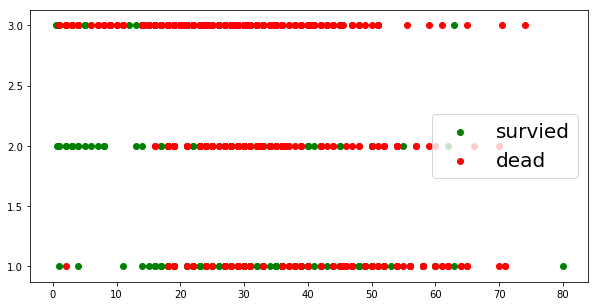

In [71]:
plt.figure(figsize=(10, 5))
plt.scatter(data['Age'][y==1], data['Pclass'][y==1], color='g', label='survied')
plt.scatter(data['Age'][y==0], data['Pclass'][y==0], color='r', label='dead')
plt.legend(fontsize=20, loc=0)
plt.show()

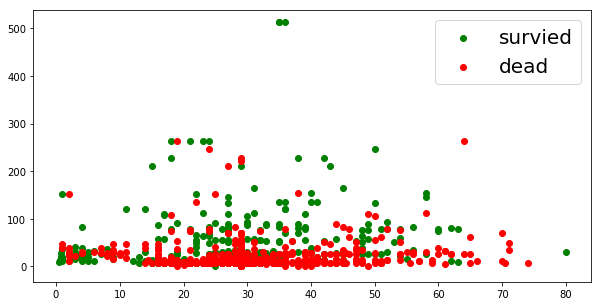

In [74]:
plt.figure(figsize=(10, 5))
plt.scatter(data['Age'][y==1], data['Fare'][y==1], color='g', label='survied')
plt.scatter(data['Age'][y==0], data['Fare'][y==0], color='r', label='dead')
plt.legend(fontsize=20, loc=0)
plt.show()

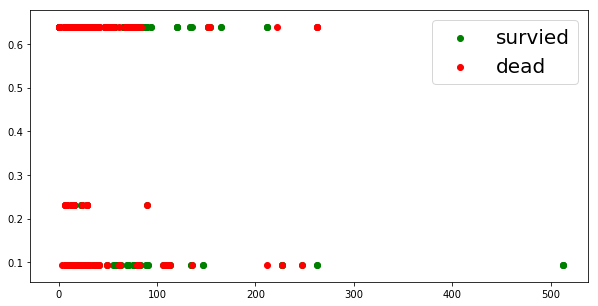

In [81]:
plt.figure(figsize=(10, 5))
plt.scatter(data['Fare'][y==1], data['Embarked'][y==1], color='g', label='survied')
plt.scatter(data['Fare'][y==0], data['Embarked'][y==0], color='r', label='dead')
plt.legend(fontsize=20, loc=0)
plt.show()

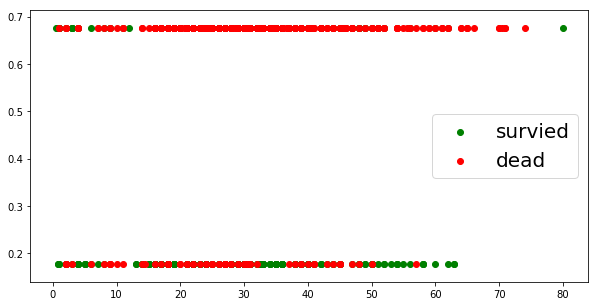

In [69]:
plt.figure(figsize=(10, 5))
plt.scatter(data['Age'][y==1], data['Sex'][y==1], color='g', label='survied')
plt.scatter(data['Age'][y==0], data['Sex'][y==0], color='r', label='dead')
plt.legend(fontsize=20, loc=0)
plt.show()

-------------------------------

#### Задание*

Для тех, кто на прошлом занятии игрался с knn.ipynb, предлагается применить knn к полученным данным, а потом получить ответы на данные из test_titakin.csv и загрузить в соревнование: https://www.kaggle.com/c/titanic. Какой результат получился и при каких k?